In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import kagglehub as kh
from kagglehub import KaggleDatasetAdapter
from sklearn.discriminant_analysis import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from plotnine import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

NORMALIZE_COUNTS = True


/home/zato-1/.venv/music/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
path = kh.dataset_download("uciml/msd-audio-features")
print("Path to dataset files:", path)
data_by_decade = pd.read_csv(path + "/year_prediction.csv")
# data_by_ear doesn't have the year labels squashed into decades
data_by_year = pd.read_csv(path + "/year_prediction.csv")

# check for NA
data_dropped = data_by_decade.dropna()
if len(data_dropped) == len(data_by_decade):
    print("No NA")

def convert_year(year):
    year_str = str(int(year["label"]))
    year_str = year_str[:-1] + '0'
    year_str += 's'
    return year_str

data_by_decade["label"] = data_by_decade.apply(convert_year, axis=1)

labels_trim = data_by_decade["label"]
labels_trim = labels_trim.replace({"2010s": "2000s"})
labels_trim = labels_trim.replace({"2000s": "2000s"})
labels_trim = labels_trim.replace({"1990s": "1990s"})
labels_trim = labels_trim.replace({"1980s": "1980s"})
labels_trim = labels_trim.replace({"1970s": "1970s"})
labels_trim = labels_trim.replace({"1960s": "<=1960s"})
labels_trim = labels_trim.replace({"1950s":  "<=1960s"})
labels_trim = labels_trim.replace({"1940s": "<=1960s"})
labels_trim = labels_trim.replace({"1930s":  "<=1960s"})
labels_trim = labels_trim.replace({"1920s":  "<=1960s"})
data_by_decade["label"] = labels_trim

data_full = data_by_decade.copy()

if NORMALIZE_COUNTS:
    min_count = data_by_decade['label'].value_counts().min()
    data_by_decade = data_by_decade.groupby('label').apply(lambda x: x.sample(min_count, replace=True)).reset_index(drop=True)

X = data_by_decade.drop(columns=[ "label"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
data_by_decade = pd.concat([pd.DataFrame(data_by_decade["label"]), pd.DataFrame(X_scaled, columns=X.columns)], axis=1)

data_by_decade["label"].value_counts()

100%|██████████| 199M/199M [00:27<00:00, 7.51MB/s] 

Extracting files...


Path to dataset files: /home/zato-1/.cache/kagglehub/datasets/uciml/msd-audio-features/versions/1
No NA


/tmp/ipykernel_7350/93347822.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


label
1970s      15673
1980s      15673
1990s      15673
2000s      15673
<=1960s    15673
Name: count, dtype: int64

In [3]:
# label
# TimbreAvg(1 - 12)
# TimberCovariance(1 - 78)
data_by_decade.head()

,label,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
0,1970s,0.149006,-0.576104,-0.042289,0.181979,-0.419532,-0.774491,1.240733,-1.015599,-0.072862,...,-0.917384,-0.400511,-0.613878,-1.060180,-0.835853,0.200101,-1.320017,-0.688574,-0.917408,-1.093499
1,1970s,-0.917789,-1.751575,0.184770,-0.455986,-0.213570,-0.202726,1.933184,0.132459,-0.628614,...,0.015601,0.338324,0.741088,-0.105459,-0.088812,0.170001,-0.064070,-0.694137,0.547331,-0.219142
2,1970s,-0.610645,-1.058098,0.094167,0.960372,0.932231,-1.238228,0.505120,-1.386956,0.012527,...,-0.958367,-0.541097,-0.650842,-0.139361,-0.831810,-1.001505,0.705336,0.082044,0.056277,0.816697
3,1970s,-1.989637,-1.137443,-2.004130,0.549939,0.787338,0.954747,0.037010,-1.900548,-1.423158,...,0.821673,0.199743,-0.078050,-0.408848,-0.142764,0.201620,0.555050,0.205436,1.128248,0.593424
4,1970s,-1.091153,0.113946,-0.073931,0.190362,0.570042,1.348695,0.574830,1.257216,-0.337827,...,-0.241524,1.352893,1.571634,0.735280,1.253149,1.163964,-0.162526,0.948648,1.135078,0.784871


Text(0.5, 0, 'Year')

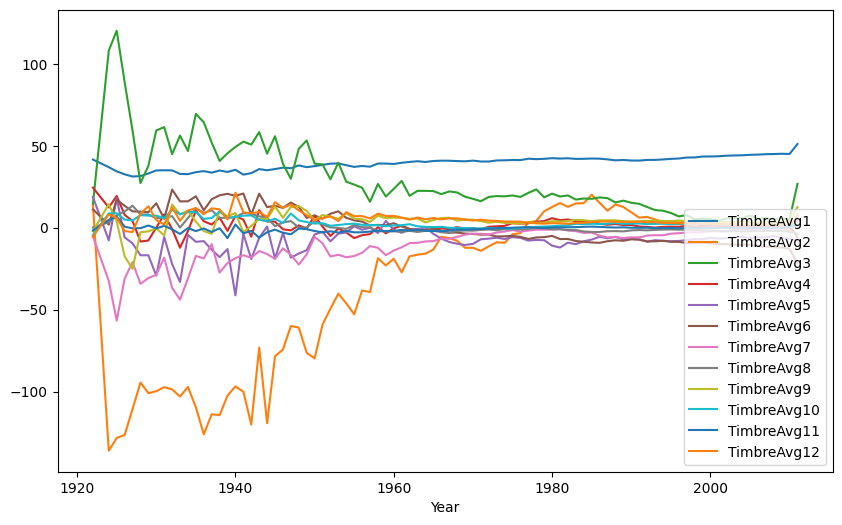

In [4]:
plt.figure(figsize=(10, 6))

ta1_means_by_decade = data_by_year.groupby('label')['TimbreAvg1'].mean()
ta2_means_by_decade = data_by_year.groupby('label')['TimbreAvg2'].mean()
ta3_means_by_decade = data_by_year.groupby('label')['TimbreAvg3'].mean()
ta4_means_by_decade = data_by_year.groupby('label')['TimbreAvg4'].mean()
ta5_means_by_decade = data_by_year.groupby('label')['TimbreAvg5'].mean()
ta6_means_by_decade = data_by_year.groupby('label')['TimbreAvg6'].mean()
ta7_means_by_decade = data_by_year.groupby('label')['TimbreAvg7'].mean()
ta8_means_by_decade = data_by_year.groupby('label')['TimbreAvg8'].mean()
ta9_means_by_decade = data_by_year.groupby('label')['TimbreAvg9'].mean()
ta10_means_by_decade = data_by_year.groupby('label')['TimbreAvg10'].mean()
ta11_means_by_decade = data_by_year.groupby('label')['TimbreAvg11'].mean()
ta12_means_by_decade = data_by_year.groupby('label')['TimbreAvg12'].mean()

plt.plot(ta1_means_by_decade, label='TimbreAvg1')
plt.plot(ta2_means_by_decade, label='TimbreAvg2')
plt.plot(ta3_means_by_decade, label='TimbreAvg3')
plt.plot(ta4_means_by_decade, label='TimbreAvg4')
plt.plot(ta5_means_by_decade, label='TimbreAvg5')
plt.plot(ta6_means_by_decade, label='TimbreAvg6')
plt.plot(ta7_means_by_decade, label='TimbreAvg7')
plt.plot(ta8_means_by_decade, label='TimbreAvg8')
plt.plot(ta9_means_by_decade, label='TimbreAvg9')
plt.plot(ta10_means_by_decade, label='TimbreAvg10')
plt.plot(ta11_means_by_decade, label='TimbreAvg11')
plt.plot(ta12_means_by_decade, label='TimbreAvg12')

plt.legend(loc='lower right')
plt.xlabel('Year')


Text(0.5, 0, 'Year')

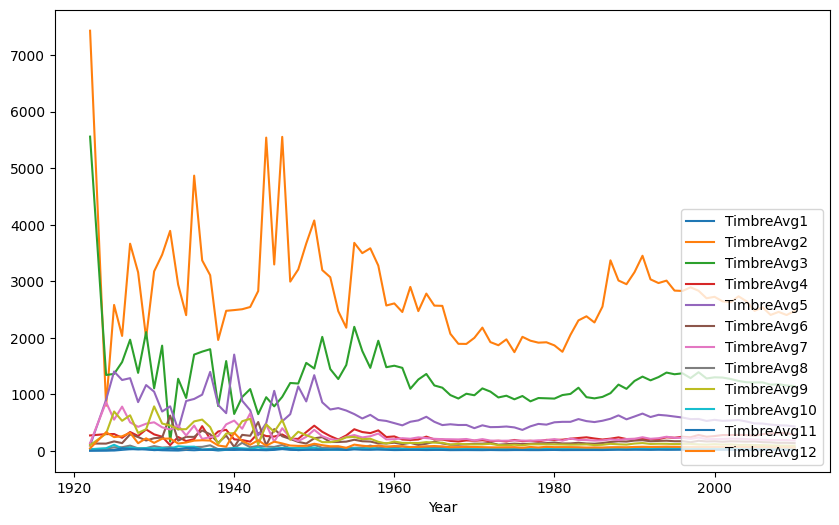

In [5]:
plt.figure(figsize=(10, 6))

ta1_means_by_decade = data_by_year.groupby('label')['TimbreAvg1'].var()
ta2_means_by_decade = data_by_year.groupby('label')['TimbreAvg2'].var()
ta3_means_by_decade = data_by_year.groupby('label')['TimbreAvg3'].var()
ta4_means_by_decade = data_by_year.groupby('label')['TimbreAvg4'].var()
ta5_means_by_decade = data_by_year.groupby('label')['TimbreAvg5'].var()
ta6_means_by_decade = data_by_year.groupby('label')['TimbreAvg6'].var()
ta7_means_by_decade = data_by_year.groupby('label')['TimbreAvg7'].var()
ta8_means_by_decade = data_by_year.groupby('label')['TimbreAvg8'].var()
ta9_means_by_decade = data_by_year.groupby('label')['TimbreAvg9'].var()
ta10_means_by_decade = data_by_year.groupby('label')['TimbreAvg10'].var()
ta11_means_by_decade = data_by_year.groupby('label')['TimbreAvg11'].var()
ta12_means_by_decade = data_by_year.groupby('label')['TimbreAvg12'].var()

plt.plot(ta1_means_by_decade, label='TimbreAvg1')
plt.plot(ta2_means_by_decade, label='TimbreAvg2')
plt.plot(ta3_means_by_decade, label='TimbreAvg3')
plt.plot(ta4_means_by_decade, label='TimbreAvg4')
plt.plot(ta5_means_by_decade, label='TimbreAvg5')
plt.plot(ta6_means_by_decade, label='TimbreAvg6')
plt.plot(ta7_means_by_decade, label='TimbreAvg7')
plt.plot(ta8_means_by_decade, label='TimbreAvg8')
plt.plot(ta9_means_by_decade, label='TimbreAvg9')
plt.plot(ta10_means_by_decade, label='TimbreAvg10')
plt.plot(ta11_means_by_decade, label='TimbreAvg11')
plt.plot(ta12_means_by_decade, label='TimbreAvg12')

plt.legend(loc='lower right')
plt.xlabel('Year')


## PCA

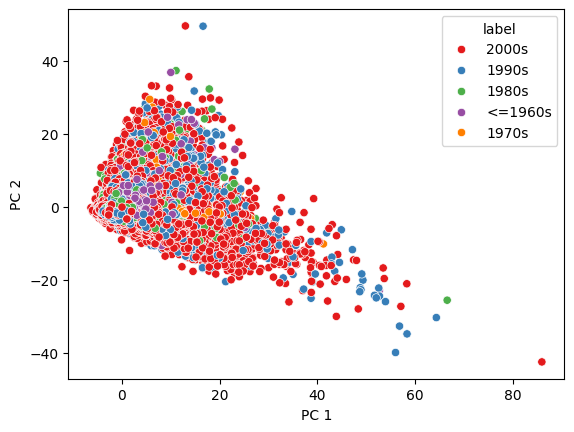

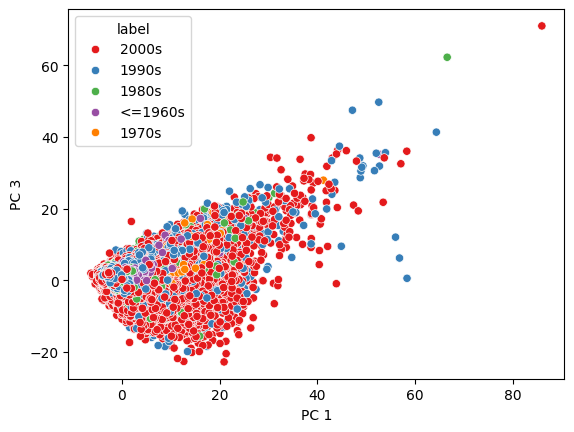

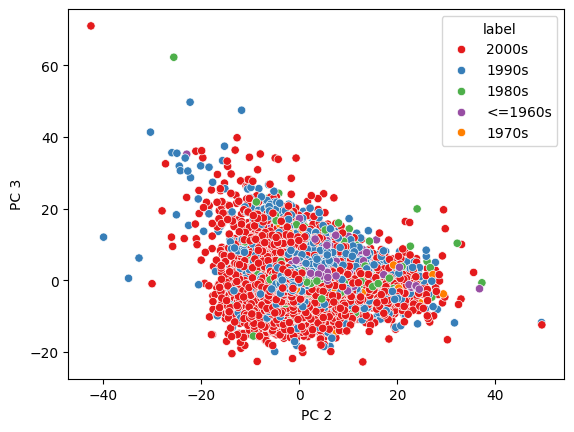

In [6]:
NUM_COMPONENTS = 9
pca = PCA(n_components=NUM_COMPONENTS)

scaler = StandardScaler()

data_by_decade = data_full.copy()

data_no_label = data_by_decade.drop('label', axis=1)
scaled_data = scaler.fit_transform(data_no_label)
pca_data = pca.fit_transform(scaled_data)
pca_data_raw = pca_data.copy()
pca_data = pd.DataFrame(pca_data, columns=[f'PC {i+1}' for i in range(NUM_COMPONENTS)])
pca_data['label'] = data_by_decade['label']

sns.scatterplot(data=pca_data, x='PC 1', y='PC 2', hue='label', palette='Set1')
plt.show()

sns.scatterplot(data=pca_data, x='PC 1', y='PC 3', hue='label', palette='Set1')
plt.show()

sns.scatterplot(data=pca_data, x='PC 2', y='PC 3', hue='label', palette='Set1') 
plt.show()

## Scree Plot (for PC count)

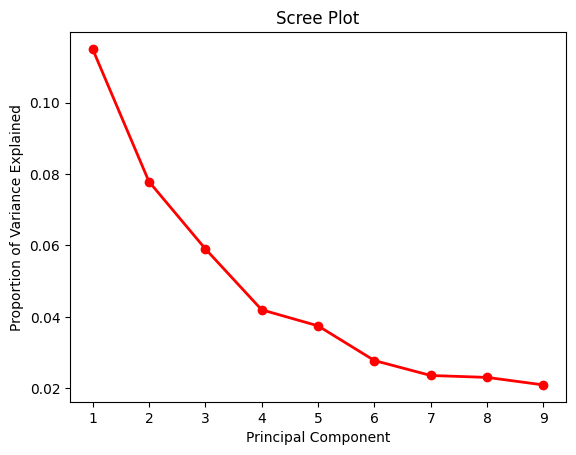

In [7]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

## K-means clustering

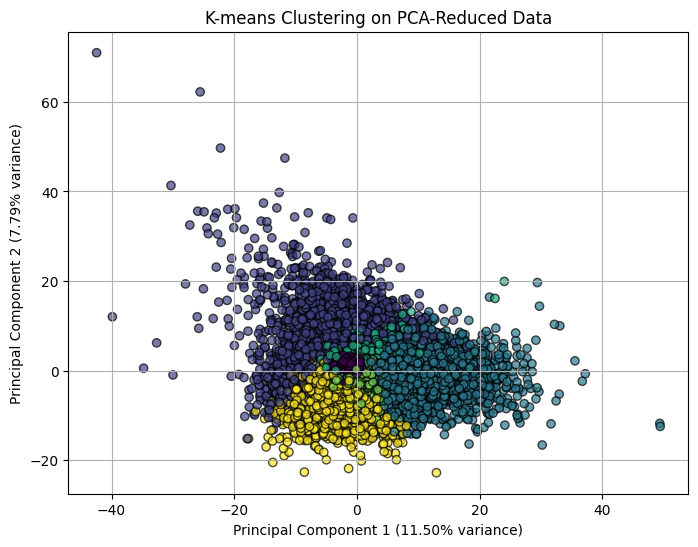

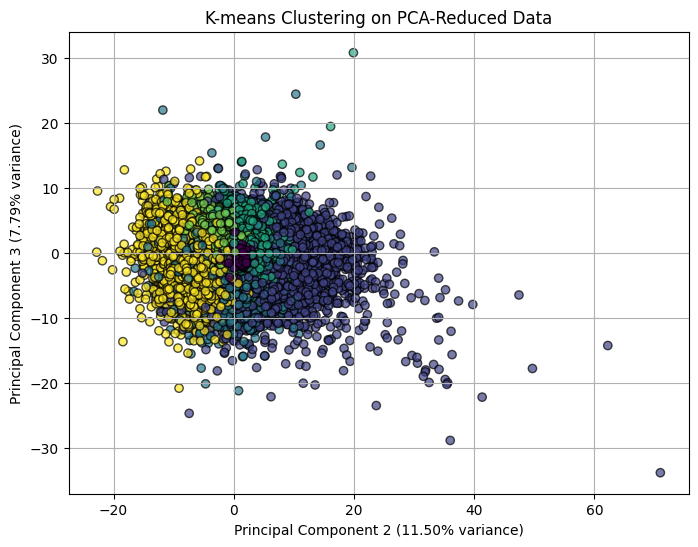

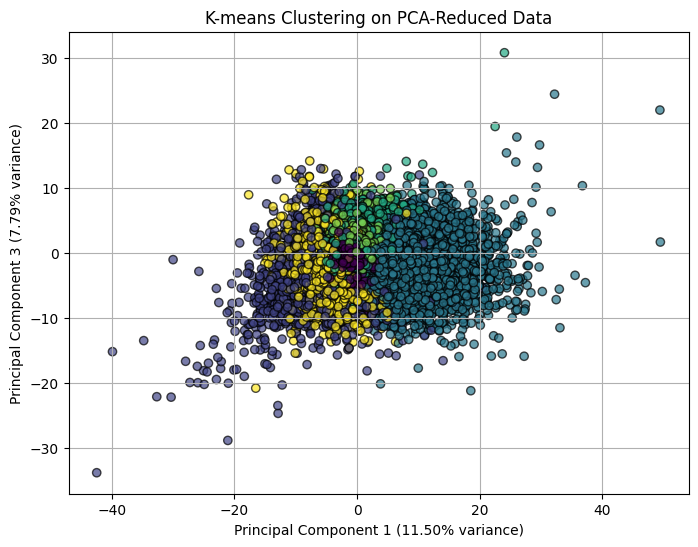

In [8]:
explained_variance = pca.explained_variance_ratio_
kmeans = KMeans(n_clusters=6, random_state=30)
s = kmeans.fit(pca_data_raw)
clusters = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(
    pca_data_raw[:, 1], pca_data_raw[:, 2], c=clusters, alpha=0.7, edgecolor='k'  
)

plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}% variance)")
plt.title("K-means Clustering on PCA-Reduced Data")
plt.grid()
plt.show();

plt.figure(figsize=(8, 6))
plt.scatter(
    pca_data_raw[:, 2], pca_data_raw[:, 3], c=clusters, alpha=0.7, edgecolor='k' 
)

plt.xlabel(f"Principal Component 2 ({explained_variance[0]*100:.2f}% variance)")
plt.ylabel(f"Principal Component 3 ({explained_variance[1]*100:.2f}% variance)")
plt.title("K-means Clustering on PCA-Reduced Data")
plt.grid()
plt.show();

plt.figure(figsize=(8, 6))
plt.scatter(
    pca_data_raw[:, 1], pca_data_raw[:, 3], c=clusters, alpha=0.7, edgecolor='k' 
)

plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% variance)")
plt.ylabel(f"Principal Component 3 ({explained_variance[1]*100:.2f}% variance)")
plt.title("K-means Clustering on PCA-Reduced Data")
plt.grid()
plt.show();


## T-SNE

/tmp/ipykernel_7350/532229977.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_7350/532229977.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


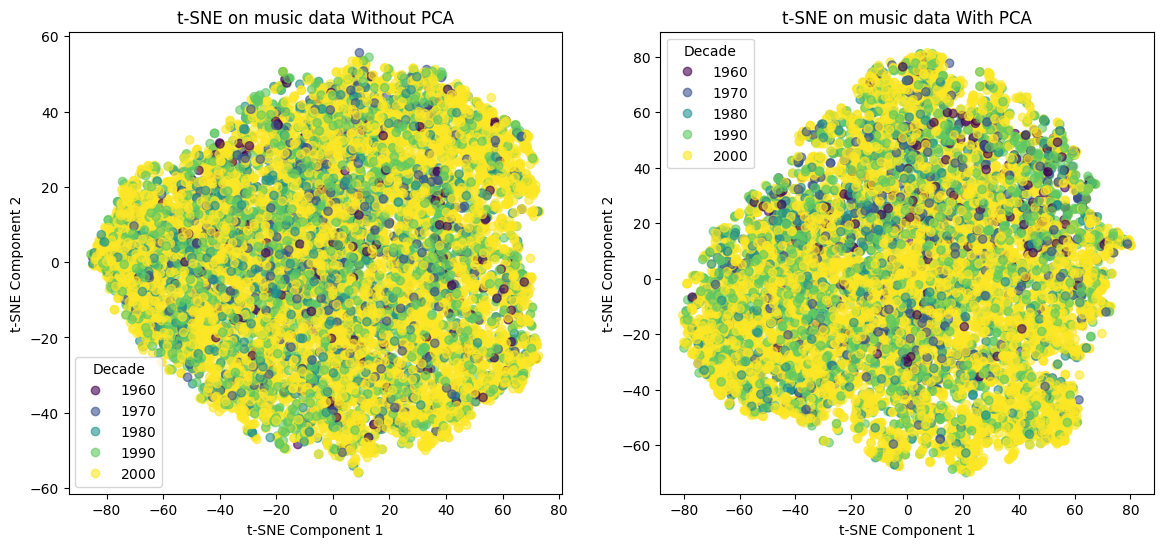

In [9]:
data_sampled, _ = train_test_split(data_by_decade, train_size=(10000 / len(data_by_decade)), random_state=42, stratify=data_by_decade["label"])
pca_sampled, _ = train_test_split(pca_data, train_size=(10000 / len(pca_data)), random_state=42, stratify=data_by_decade["label"])

labels_trim = data_sampled["label"]
pca_labels_trim = pca_sampled["label"]
data_sampled = data_sampled.drop(["label"], axis=1)
pca_sampled = pca_sampled.drop(["label"], axis=1)

labels_trim = labels_trim.replace({"2010s": 2000})
labels_trim = labels_trim.replace({"2000s": 2000})
labels_trim = labels_trim.replace({"1990s": 1990})
labels_trim = labels_trim.replace({"1980s": 1980})
labels_trim = labels_trim.replace({"1970s": 1970})
labels_trim = labels_trim.replace({"1960s": 1960})
labels_trim = labels_trim.replace({"<=1960s": 1960})
labels_trim = labels_trim.replace({"1950s": 1960})
labels_trim = labels_trim.replace({"1940s": 1960})
labels_trim = labels_trim.replace({"1930s": 1960})
labels_trim = labels_trim.replace({"1920s": 1960})

pca_labels_trim = pca_labels_trim.replace({"2010s": 2000})
pca_labels_trim = pca_labels_trim.replace({"2000s": 2000})
pca_labels_trim = pca_labels_trim.replace({"1990s": 1990})
pca_labels_trim = pca_labels_trim.replace({"1980s": 1980})
pca_labels_trim = pca_labels_trim.replace({"1970s": 1970})
pca_labels_trim = pca_labels_trim.replace({"1960s": 1960})
pca_labels_trim = pca_labels_trim.replace({"<=1960s": 1960})
pca_labels_trim = pca_labels_trim.replace({"1950s": 1960})
pca_labels_trim = pca_labels_trim.replace({"1940s": 1960})
pca_labels_trim = pca_labels_trim.replace({"1930s": 1960})
pca_labels_trim = pca_labels_trim.replace({"1920s": 1960})

labels_trim = labels_trim.to_list()
pca_labels_trim = pca_labels_trim.to_list()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_no_pca = tsne.fit_transform(data_sampled)
tsne_pca = tsne.fit_transform(pca_sampled)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

s1 = ax[0].scatter(tsne_no_pca[:, 0], tsne_no_pca[:, 1], c=labels_trim, cmap="viridis", alpha=0.6)
ax[0].set_title("t-SNE on music data Without PCA")
ax[0].set_xlabel("t-SNE Component 1")
ax[0].set_ylabel("t-SNE Component 2")
ax[0].legend(*s1.legend_elements(), title="Decade")

s2 = ax[1].scatter(tsne_pca[:, 0], tsne_pca[:, 1], c=pca_labels_trim, cmap="viridis", alpha=0.6)
ax[1].set_title("t-SNE on music data With PCA")
ax[1].set_xlabel("t-SNE Component 1")
ax[1].set_ylabel("t-SNE Component 2")
ax[1].legend(*s2.legend_elements(), title="Decade")

plt.show()